This notebook is for developing suplemental figure 4.

It works together with scripts "deploy_shuffle_clustering.py" and "run_shuffle_clustering.py" which are in vba repo, to generate shuffled datasets, coclustering matrices and labels for each type of shuffle.

For the scope of supplemental figure 4, I will only use "experience" and "experience_within_cell" shuffle types for figures.

Making SSE figures. 



In [1]:
import os
import numpy as np

import visual_behavior.data_access.loading as loading
import visual_behavior.data_access.utilities as utilities

from visual_behavior.dimensionality_reduction.clustering import plotting
from visual_behavior.dimensionality_reduction.clustering import processing

import seaborn as sns

sns.set_context('notebook', font_scale=1, rc={'lines.markeredgewidth': 1})



In [2]:
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import visual_behavior_glm.GLM_analysis_tools as gat
from visual_behavior.dimensionality_reduction import clustering as vba_clust

In [4]:
import visual_behavior.visualization.utils as utils
import visual_behavior_glm.GLM_analysis_tools as gat

palette_experience = utils.get_experience_level_colors()
palette_cre = utils.get_cre_line_colors()

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [6]:

# # load experiments table
experiments_table = loading.get_platform_paper_experiment_table()
# # limit to closest familiar and novel active
experiments_table = utilities.limit_to_last_familiar_second_novel_active(experiments_table)
experiments_table = utilities.limit_to_containers_with_all_experience_levels(experiments_table)

# load matched cells table
cells_table = loading.get_cell_table()
cells_table = loading.get_matched_cells_table(cells_table)
matched_cells = cells_table.cell_specimen_id.unique()
matched_experiments = cells_table.ophys_experiment_id.unique()

# get cre_lines and cell types for plot labels
cre_lines = np.sort(cells_table.cre_line.unique())
cell_types = utilities.get_cell_types_dict(cre_lines, experiments_table)


c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments


c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments
3921 cells in matched cells table


In [7]:
figsizes = [(20,7), (10,7), (20,7)]
thresholds = [0.10]

In [8]:
# get GLM output, filter and reshape
glm_version = '24_events_all_L2_optimize_by_session'
model_output_type = 'adj_fraction_change_from_full'

In [9]:
# set params for saving
folder = '240101_SSE_general'
file_dir = '240101_shuffle_test'

In [10]:
base_dir = '//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_plots/figure_4'
base_dir = os.path.join(base_dir, 'all_cre_clustering_082823_n_14')
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

In [11]:
# create folder to load and save to
save_dir = os.path.join(base_dir, folder)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    
# create folder to load and save to
file_dir = os.path.join(base_dir, file_dir)
if not os.path.exists(file_dir):
    os.mkdir(file_dir)

#### Load original feature matrix,, meta data and cluster labels

In [12]:
filename = '24_events_all_L2_optimize_by_session_feature_matrix.h5'
feature_matrix = pd.read_hdf(os.path.join(base_dir, filename), key='df')

In [13]:
filename = 'cluster_meta_n_14_clusters.h5'
df_meta = pd.read_hdf(os.path.join(base_dir, filename))

In [14]:
df_meta.head()

,cell_specimen_id,ophys_experiment_id,cre_line,cluster_id,labels,within_cluster_correlation
0,1086489847,1003771765,Vip-IRES-Cre,8,1,0.477738
1,1086489860,1003771765,Vip-IRES-Cre,1,5,0.532181
2,1086489891,1003771765,Vip-IRES-Cre,8,1,0.638229
3,1086489976,962471831,Sst-IRES-Cre,3,9,0.480384
4,1086490002,962471831,Sst-IRES-Cre,3,9,0.761853


In [16]:
np.sort(df_meta.cluster_id.unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

In [17]:
cre_lines = np.sort(df_meta['cre_line'].unique())
cre_line_dfs = {}
for cre_line in cre_lines:
    cids = df_meta[df_meta['cre_line']==cre_line].cell_specimen_id.values
    df_cre = feature_matrix.loc[cids].copy()
    cre_line_dfs[cre_line] = df_cre

#### compute mean dropout scores for original data

In [18]:
cre_mean_dropout_scores = {}
for cre_line in cre_lines:
    dropout_scores = cre_line_dfs[cre_line]
    cluster_df = df_meta[df_meta.cre_line == cre_line]

    mean_dropout_scores = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                  cluster_df = cluster_df)
    cre_mean_dropout_scores[cre_line] = mean_dropout_scores

In [19]:
original_min_max = {}
for cre_line in cre_lines:
    cluster_df = df_meta[df_meta.cre_line == cre_line]
    min_cluster = cluster_df[['cluster_id']].value_counts().min()
    max_cluster = cluster_df[['cluster_id']].value_counts().max()
    original_min_max[cre_line] = [min_cluster, max_cluster]

    print(100/len(cluster_df)*min_cluster)
    print(100/len(cluster_df)*max_cluster)

0.7580351728320194
21.89205579138872
3.092783505154639
26.804123711340203
1.7114914425427872
21.271393643031782


In [20]:
df_meta['cluster_id']=df_meta['cluster_id']+1

In [21]:
save_dir

'//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_plots/figure_4\\all_cre_clustering_082823_n_14\\240101_SSE_general'

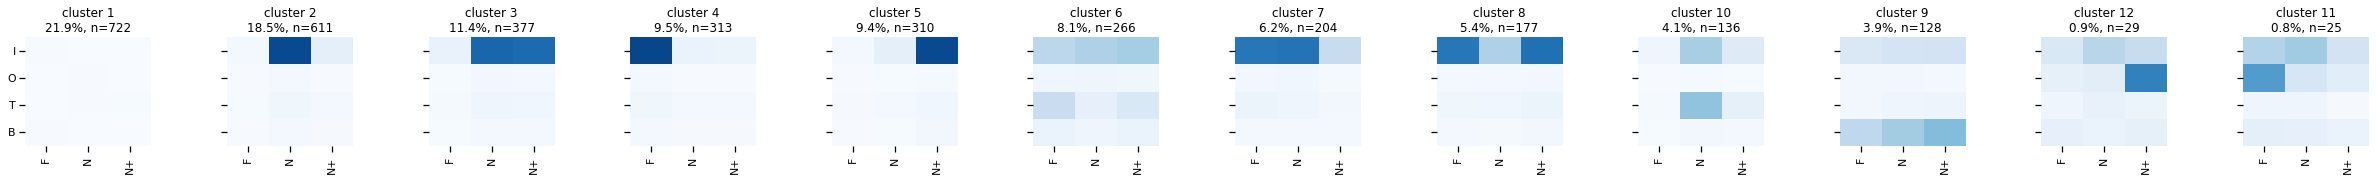

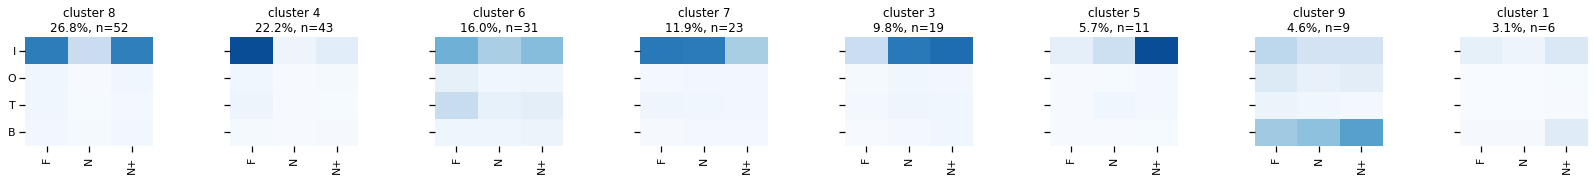

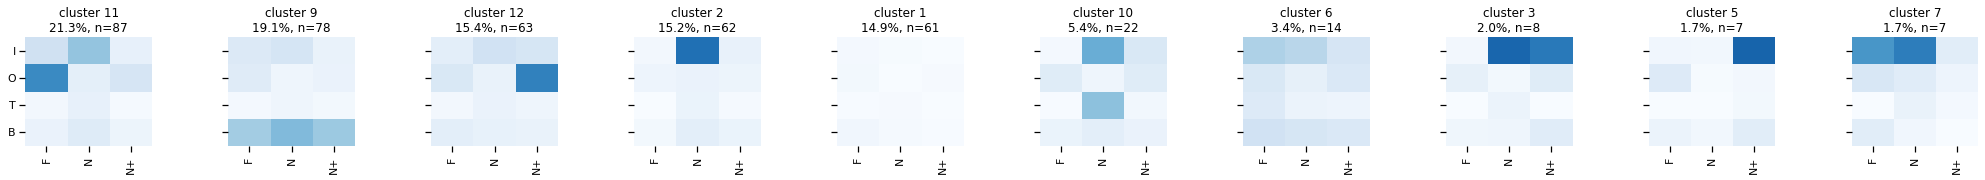

In [22]:
# plot original clusters
for cre_line in cre_lines:
    feature_matrix = cre_line_dfs[cre_line]
    cluster_df = df_meta[df_meta.cre_line == cre_line].set_index('cell_specimen_id')
    sort_order = {cre_line: vba_clust.get_sorted_cluster_ids(cluster_df)}
    vba_clust.plot_clusters_row(cluster_df, feature_matrix, cre_line,
                               sort_order=sort_order, save_dir=save_dir, folder='', suffix='_original',
                                )


#### load shuffled datasets into one dictionary

In [23]:
shuffle_types = ['full_experience']#['experience', 'experience_within_cell','full_experience']
# randomize 150 samples of shuffled data
# n_boots = np.random.randint(0, 500, 150)
n_boots = np.arange(500)

#### load cluster labels for each dataset into one dictionary

In [36]:
filedir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4\all_cre_clustering_082823_n_14\240101_shuffle_test\files'

In [35]:
%%time
# this takes a few minutes
shuffle_type_df = {}
for shuffle_type in shuffle_types:
    nb_shuffled = {}
    for n, n_boot in enumerate(n_boots):
        nb_filename ='all_cells_{}_nb{}.h5'.format(shuffle_type, n_boot)
        nb_shuffled[n] = pd.read_hdf(os.path.join(filedir,nb_filename), key = 'df')

    shuffle_type_df[shuffle_type] = nb_shuffled

Wall time: 21.7 s


In [57]:
%%time
shuffle_type_labels = {}
for shuffle_type in shuffle_types:
    nb_labels_shuffled = {}                       
    for n, n_boot in enumerate(n_boots):
        nb_filename ='all_cells_{}_nb{}_cluster_labels.h5'.format(shuffle_type, n_boot) 
        full_filename = os.path.join(filedir, nb_filename)
        nb_labels_shuffled[n] = pd.read_hdf(full_filename, key = 'clustered_df')
    shuffle_type_labels[shuffle_type] = nb_labels_shuffled
    

Wall time: 35.4 s


In [64]:
shuffle_type_labels[shuffle_type][n]

,cell_specimen_id,cre_line,cluster_id,labels
0,1086490067,Slc17a7-IRES2-Cre,3,2
1,1086490073,Slc17a7-IRES2-Cre,9,8
2,1086490095,Slc17a7-IRES2-Cre,4,3
3,1086490129,Slc17a7-IRES2-Cre,7,6
4,1086490246,Slc17a7-IRES2-Cre,9,8
...,...,...,...,...
3896,1086673279,Vip-IRES-Cre,9,8
3897,1086673299,Vip-IRES-Cre,12,11
3898,1086673376,Vip-IRES-Cre,12,11
3899,1086673402,Vip-IRES-Cre,12,11


In [65]:
shuffle_type_df[shuffle_type][n]

all-images                     omissions                      \
experience_level   Familiar   Novel 1  Novel >1  Familiar   Novel 1  Novel >1   
cell_specimen_id                                                                
1086490067         0.806462  0.295716  0.796747  0.000000  0.041023  0.000000   
1086490073         0.000000  0.082906  0.422951  0.000000  0.000000  0.000000   
1086490095         1.000000  1.000000  0.888086  0.000000  0.000000  0.021626   
1086490129         0.603296  0.000000  0.474990  0.000000  0.000000  0.056756   
1086490246         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...                     ...       ...       ...       ...       ...       ...   
1086673279         0.000000  0.393269  0.000000  0.000000  0.000000  0.000000   
1086673299         0.000000  0.227504  0.000000  0.723846  0.540536  0.000000   
1086673376         0.183287  0.000000  0.408181  0.194553  0.000000  0.640066   
1086673402         0.933197  0.227848  0.663293  0.715912  0.042116  0.000000   
1086673591         0.000000  0.812928  0.000000  1.000000  0.087783  0.307902   

                 behavioral                          task                      
experience_level   Familiar   Novel 1  Novel >1  Familiar   Novel 1  Novel >1  
cell_specimen_id                                                               
1086490067         0.000000  0.000000  0.000000  0.262974  0.113139  0.240487  
1086490073         0.000000  0.250759  0.146213  0.958002  0.000000  0.000849  
1086490095         0.000000  0.000000  0.003504  0.000000  0.000000  0.023006  
1086490129         0.000000  0.000000  0.067625  0.016608  0.000000  0.363998  
1086490246         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
...                     ...       ...       ...       ...       ...       ...  
1086673279         0.000000  0.182458  0.000000  0.000000  0.111758  0.000000  
1086673299         0.000000  0.288167  0.000000  0.000000  0.128685  0.000000  
1086673376         0.484351  0.000000  0.043770  0.109487  0.000000  0.000000  
1086673402         0.040501  0.071843  0.479010  0.008037  0.000000  0.110401  
1086673591         0.000000  0.000000  0.019647  0.000000  0.024179  0.138815  

[3901 rows x 12 columns]

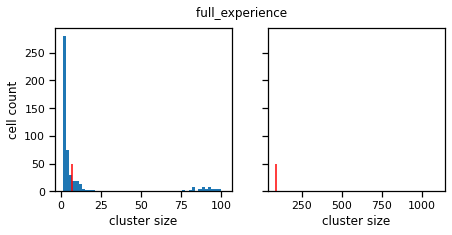

In [59]:
### plot minimum and maximum cluster size in the shuffles
for shuffle_type in shuffle_types:
    min_clusters = []
    max_clusters = []
    for n, n_boot in enumerate(n_boots):
        x = shuffle_type_labels[shuffle_type][n][['cluster_id']].value_counts().min()
        min_clusters.append(x)
            
        y = shuffle_type_labels[shuffle_type][n][['cluster_id']].value_counts().max()
    max_clusters.append(y)
    fig, ax = plt.subplots(1,2, figsize = (7,3), sharey = 'row')
    ax[0].hist(min_clusters, 50)
    ax[0].vlines(x=original_min_max[cre_line][0], ymin=0, ymax=50, color='r')
    ax[0].set_ylabel('cell count')
    ax[0].set_xlabel('cluster size')
    ax[1].hist(max_clusters, 50)
    ax[1].vlines(x=original_min_max[cre_line][1], ymin=0, ymax=50, color='r')
    ax[1].set_xlabel('cluster size')
    plt.suptitle(shuffle_type +' ')
    utils.save_figure(fig, figsize = (7,3), save_dir=save_dir, folder='plots',
                          fig_title=f'min_max_cluster_size_{shuffle_type}')
            

#### compute mean dropout scores for shuffled dfs


In [66]:
shuffle_type_mean_dropout_scores = {} # shuffle types to compare
for shuffle_type in shuffle_types:
    cre_mean_dropout_scores_shuffled = {} # cre lines to compare
    for cre_line in cre_lines:
        nb_mean_dropout_scores_shuffled = {}
        for n, n_boot in enumerate(n_boots):
            tmp = shuffle_type_labels[shuffle_type][n]
            cluster_df = tmp[tmp.cre_line==cre_line]
            cids = cluster_df.cell_specimen_id.values
            
            tmp = shuffle_type_df[shuffle_type][n]
            dropout_scores = tmp.loc[cids] 
            mean_dropout_scores = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                      cluster_df = cluster_df)
            nb_mean_dropout_scores_shuffled[n] = mean_dropout_scores
        cre_mean_dropout_scores_shuffled[cre_line] = nb_mean_dropout_scores_shuffled
    shuffle_type_mean_dropout_scores[shuffle_type] = cre_mean_dropout_scores_shuffled

In [25]:
### this takes a lot of time so run it at your own risk
### plot clusters
# for shuffle_type in shuffle_types[::-1]:
#     for cre_line in cre_lines[::-1]:
#         for n, n_boot in enumerate(n_boots[:50]):
#             feature_matrix = shuffle_type_df[shuffle_type][cre_line][n]
#             cluster_df = shuffle_type_labels[shuffle_type][cre_line][n].set_index('cell_specimen_id')
#             sort_order = {cre_line: vba_clust.get_sorted_cluster_ids(cluster_df)}
#             vba_clust.plot_clusters_row(cluster_df, feature_matrix, cre_line,
#                                    sort_order=sort_order, rename_clusters=True, save_dir=save_dir, folder='shuffled_plots', 
#                                         suffix='_nb'+str(n_boot)+'_'+shuffle_type)
#             plt.close('all')

### compute SSE

In [67]:
shuffle_type_SSE = {}
for shuffle_type in shuffle_types:
    cre_SSE = {}
    for cre_line in cre_lines:
        nb_sse = {}
        original_df = cre_mean_dropout_scores[cre_line]
        for n, n_boot in enumerate(n_boots):
            shuffled_df = shuffle_type_mean_dropout_scores[shuffle_type][cre_line][n]
            sse = vba_clust.compute_SSE(original_df, shuffled_df)
            nb_sse[n] = sse
        cre_SSE[cre_line] = nb_sse
    shuffle_type_SSE[shuffle_type] = cre_SSE
        

### get cluster mapping

In [68]:
threshold_SSE_mapping = {}
for threshold in thresholds:
    shuffle_type_SSE_mapping = {}
    for shuffle_type in shuffle_types:
        cre_SSE_mapping = {}
        for cre_line in cre_lines:
            nb_sse_mapping = {}
            nb_matrix = shuffle_type_SSE[shuffle_type][cre_line]
            cluster_mapping = vba_clust.get_cluster_mapping(nb_matrix, threshold = threshold)
            cre_SSE_mapping[cre_line] = cluster_mapping
        shuffle_type_SSE_mapping[shuffle_type] = cre_SSE_mapping
    threshold_SSE_mapping[threshold] = shuffle_type_SSE_mapping


In [69]:
shuffle_type_dict = {}
shuffle_type_dict['experience']='cell ID'
shuffle_type_dict['experience_within_cell']='labels'
shuffle_type_dict['full_experience']='both'


In [70]:

shuffle_type_SSE_values = {}
for shuffle_type in shuffle_types:
    cre_SSE_values = {}
    for cre_line in cre_lines:
        nb_matrix = shuffle_type_SSE[shuffle_type][cre_line]
        cluster_mapping_SSE = vba_clust.get_mapped_SSE_values(nb_matrix, threshold = threshold)
        cre_SSE_values[cre_line] = cluster_mapping_SSE
    shuffle_type_SSE_values[shuffle_type] = cre_SSE_values


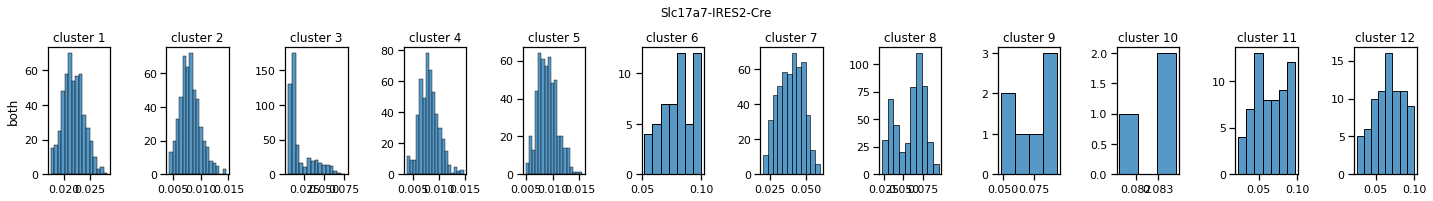

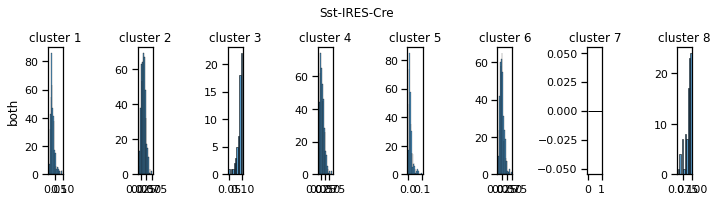

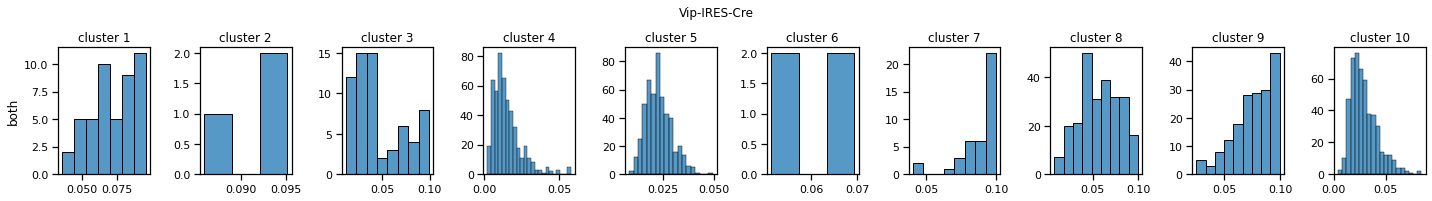

In [71]:
for c,cre_line in enumerate(cre_lines):
    fig = plt.figure(figsize=figsizes[c], )
    ax_i =1
    for s,shuffle_type in enumerate(shuffle_types):
        tmp = shuffle_type_SSE_values[shuffle_type][cre_line]
        cluster_ids = tmp.keys()
        
        for i,cluster_id in enumerate(cluster_ids):
            ax = fig.add_subplot(3, len(cluster_ids), ax_i, )
            ax = sns.histplot(tmp[cluster_id], ax=ax, )
            if s == 0:
                ax.set_title(f'cluster {cluster_id}')
                
            if cluster_id !=1:
                ax.set_ylabel('')
            else:
                ax.set_ylabel(shuffle_type_dict[shuffle_type])
            ax_i=ax_i+1
            #ax.set_xlim([0, threshold])
    fig.suptitle(cre_line)
        
    plt.tight_layout()
    utils.save_figure(fig, figsize = figsizes[c], save_dir=save_dir, folder=f'SSE_hist_by_cluster_{threshold}',
                          fig_title=f'SSE_hist_{cre_line}')
    
# this code blocke plots one row at a time (for easier editing if needed)
# for shuffle_type in shuffle_types:
#     for cre_line in cre_lines:
#         tmp = shuffle_type_SSE_values[shuffle_type][cre_line]
#         cluster_ids = tmp.keys()
#         fig, ax = plt.subplots(1,len(cluster_ids), figsize = (15,3), sharey = "row")
#         for i,cluster_id in enumerate(cluster_ids):
#             ax[i] = sns.histplot(tmp[cluster_id], ax=ax[i], )
#             ax[i].set_title(f'cluster {cluster_id}')
#             #ax[i].set_xlim([0, threshold])
#         plt.suptitle(shuffle_type + ' ' + cre_line)
#         plt.tight_layout()
#         utils.save_figure(fig, figsize = (15,3), save_dir=save_dir, folder='SSE_by_cluster',
#                           fig_title=f'SSE_hist_{cre_line}_{shuffle_type}_{threshold}')

#### Plot SSE 

In [72]:
for shuffle_type in shuffle_types:
    for cre_line in cre_lines:
        for n, n_boot in enumerate(n_boots[:50]):
            tmp = shuffle_type_SSE[shuffle_type][cre_line][n_boot]
            labels=np.arange(1,len(tmp)+1)
            fig, ax = plt.subplots(1,1,figsize = (10,10))
            ax=sns.heatmap(tmp, annot=True, cmap = 'Greys', 
                           yticklabels=labels, xticklabels=labels,ax=ax)
            plt.suptitle(cre_line[:3]+ ' ' + shuffle_type + ' ' + str(n_boot))
            plt.tight_layout()
            utils.save_figure(fig, figsize = (10,10), save_dir=save_dir, folder='SSE', 
                      fig_title=f'SSE_matrix{cre_line[:3]}_nb{n_boot}_{shuffle_type}')
            plt.close('all')

#### Plot cluster heatmaps with SSE matrix together

In [32]:
#create unstacked mean dropout scores for each cluster for plotting
cre_original_clusters_unstacked = {}
for cre_line in cre_lines:
    dropout_scores = cre_line_dfs[cre_line]
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line]

    mean_dropout_scores = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                  cluster_df = cluster_df, stacked=False)
    # This is a bandaid fix for clusters 4 and 5 being switched in get_mean_dropout_scores_per_cluster function for some reason, 
    # which makes matching clusters confusing. 
    if cre_line == 'Slc17a7-IRES2-Cre':
        mean_dropout_scores[100] = mean_dropout_scores.pop(4)
        mean_dropout_scores[4] = mean_dropout_scores.pop(5)
        mean_dropout_scores[5] = mean_dropout_scores.pop(100)
    cre_original_clusters_unstacked[cre_line] = mean_dropout_scores
            

next cell plots SSE matrix with shuffled and original clusters

In [33]:
# import matplotlib.gridspec as gr
# figsizes =  [(20,15), (15, 15), (20,15)]
# for shuffle_type in shuffle_types:
#     for n,n_boot in enumerate(n_boots[50:100]):
#         for c,cre_line in enumerate(cre_lines):
#             shuffled = shuffle_type_mean_dropout_scores_unstacked[shuffle_type][cre_line][n]
#             original = cre_original_clusters_unstacked[cre_line]
#             cluster_ids = shuffled.keys()
#             n_clusters = len(cluster_ids)
            
            
#             gs = gr.GridSpec(n_clusters+1, n_clusters+1, width_ratios=[2]*(n_clusters+1), height_ratios=[2]*(n_clusters+1))
#             fig = plt.figure(figsize = figsizes[c])
            
#             # plot shuffled
#             for i, cluster_id in enumerate(cluster_ids):
#                 ax = fig.add_subplot(gs[0, i])
#                 ax = sns.heatmap(shuffled[cluster_id].loc[vba_clust.get_features_for_clustering()],
#                     xticklabels=['F', 'N', 'N+'],yticklabels=['I', 'O', 'B', 'T'],
#                     cmap = "Blues",vmin=0, vmax=1,cbar=False, ax=ax)
#                 if i!=0:
#                     ax.set_yticklabels('')
#                 ax.set_xticklabels('')
#                 ax.set_xlabel('')
                
#             # plot original clusters
#             for i, cluster_id in enumerate(cluster_ids):
#                 ax = fig.add_subplot(gs[cluster_id, n_clusters])
#                 ax = sns.heatmap(original[cluster_id].loc[vba_clust.get_features_for_clustering()],
#                     xticklabels=['F', 'N', 'N+'],yticklabels=['I', 'O', 'B', 'T'],
#                     cmap = "Blues",vmin=0, vmax=1,cbar=False, ax=ax)
#                 ax.set_yticklabels('')
#                 ax.set_xlabel('')
#                 if cluster_id !=n_clusters:
#                     ax.set_xticklabels('')
                
                
#              # Plot SSE
#             tmp = shuffle_type_SSE[shuffle_type][cre_line][n]
#             labels=np.arange(1,len(tmp)+1)
#             ax = fig.add_subplot(gs[1:,:n_clusters])
#             ax=sns.heatmap(tmp, annot=True, cmap = 'Greys', 
#                                 yticklabels=labels, xticklabels=labels,cbar=False,ax=ax)
         
#             plt.tight_layout()
#             utils.save_figure(fig, figsize = figsizes[c], save_dir=save_dir, folder=os.path.join(shuffle_type, cre_line[:3], 'SSE_plots'),
#                           fig_title=f'SSE_hist_{shuffle_type}_{cre_line[:3]}_nb{n_boot}', formats=['.png'])
#             plt.close('all')


#### plotting aligned clusters into one folder
This will make it easier to scroll through plots and to make sure that all matched clusters are well matched


In [34]:
#create unstacked mean dropout scores for each cluster for plotting
shuffle_type_mean_dropout_scores_unstacked = {} # shuffle types to compare
for shuffle_type in shuffle_types:
    cre_mean_dropout_scores_shuffled_unstacked = {} # cre lines to compare
    for cre_line in cre_lines:
        nb_mean_dropout_scores_shuffled = {}
        for n,n_boot in enumerate(n_boots):
            dropout_scores = shuffle_type_df[shuffle_type][cre_line][n]
            cluster_df = shuffle_type_labels[shuffle_type][cre_line][n]
            #cluster_df = cluster_df.rename(mapper={'labels':'cluster_id'}, axis=1)
            mean_dropout_scores_unstacked = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                      cluster_df = cluster_df, stacked=False)
            nb_mean_dropout_scores_shuffled[n] = mean_dropout_scores_unstacked
        cre_mean_dropout_scores_shuffled_unstacked[cre_line] = nb_mean_dropout_scores_shuffled
    shuffle_type_mean_dropout_scores_unstacked[shuffle_type] = cre_mean_dropout_scores_shuffled_unstacked

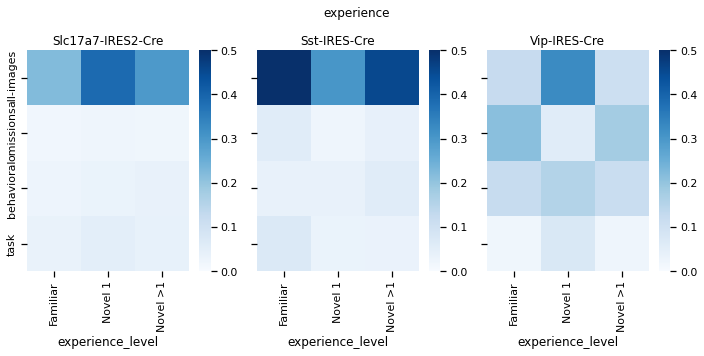

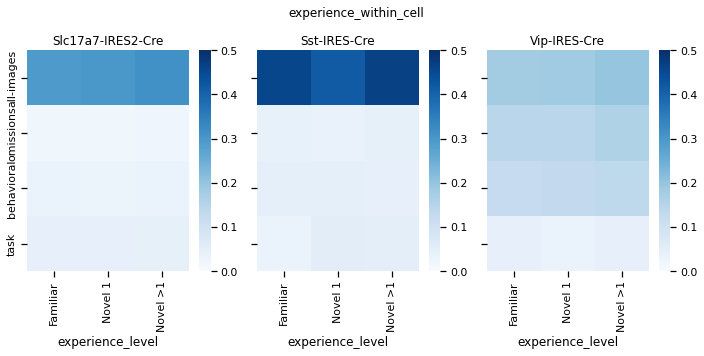

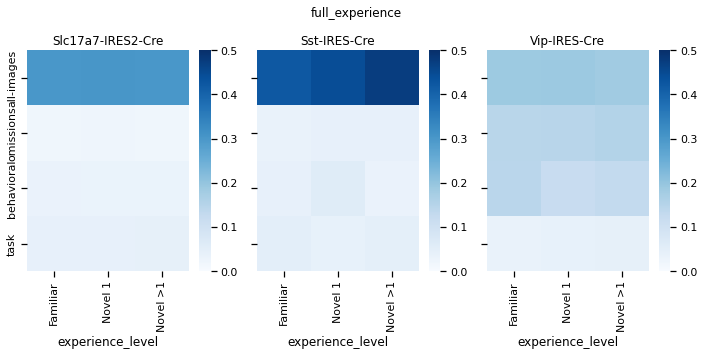

In [35]:
### pot mean of shuffled dropout scores regardless of clusters.
for shuffle_type in shuffle_types:
    fig, ax = plt.subplots(1,3, figsize = (10,5), sharey='row')
    for c, cre_line in enumerate(cre_lines):
        for n, n_boot in enumerate(n_boots):
            if n ==0:
                dropout_scores = shuffle_type_df[shuffle_type][cre_line][n]
            else:
                dropout_scores.append(shuffle_type_df[shuffle_type][cre_line][n], ignore_index=True)
        mean_df = dropout_scores.mean().unstack()
        features = vba_clust.get_features_for_clustering()
        mean_df = mean_df.loc[features]
        ax[c] = sns.heatmap(mean_df, cmap='Blues', ax=ax[c], vmin=0, vmax=0.5)
        ax[c].set_title(cre_line)
    plt.suptitle(shuffle_type)
    plt.tight_layout()
    utils.save_figure(fig, figsize = (10,5), save_dir=save_dir, folder='', fig_title=f'mean_dropout_scores_{shuffle_type}_{threshold}')

In [36]:

# # This takes forever, so commenting it out unless it's needed
# # plot
# vmin = 0
# cmap = 'Blues'
# # loop through the thresholds first
# for threshold in thresholds:
#     shuffle_type_SSE_mapping = threshold_SSE_mapping[threshold]
#     #shuffle_types = shuffle_type_SSE_mapping.keys()
    
#     # loop through shuffle types
#     for shuffle_type in shuffle_types[::-1]:
#         #cre_lines = shuffle_type_SSE_mapping[shuffle_type].keys()
        
#         # loop through cre lines
#         for cre_line in cre_lines[::-1]:
#             # n_boots = shuffle_type_SSE_mapping[shuffle_type][cre_line].keys()
#             # n_boots is already specified. You cant select a handful when using dictionary keys so commenting it out
            
#             # plot only a few examples for speed
#             for n_boot in n_boots[100:130]:

#                 cluster_ids = shuffle_type_SSE_mapping[shuffle_type][cre_line][n_boot].keys()
#                 for cluster_id in cluster_ids:
#                     matched_cluster_id = shuffle_type_SSE_mapping[shuffle_type][cre_line][n_boot][cluster_id]
#                     if matched_cluster_id !=-1:
#                         dropout_scores = shuffle_type_mean_dropout_scores_unstacked[shuffle_type][cre_line][n_boot][matched_cluster_id]

#                         # plot cluster
#                         fig, ax = plt.subplots()    
#                         sns.heatmap(dropout_scores,cmap = cmap, vmin=vmin, vmax=1, ax = ax,)
#                         ax.set_title(f'cre_line:{cre_line}, clust_id:{cluster_id}, nb:{n_boot}')

#                         # save
#                         this_folder = os.path.join(shuffle_type+str(threshold), cre_line[:3], f'cluster_{cluster_id}')
#                         this_dir = os.path.join(save_dir, this_folder)
#                         if not os.path.exists(this_dir):
#                             os.makedirs(this_dir)    
#                         plt.tight_layout()
#                         figname = 'nb_{}.png'.format(n_boot)
#                         fig.savefig(os.path.join(this_dir, figname))

#                         plt.close('all')

#                 # plot all unmatched clusters into one folder
#                 # all matched cluster ids
#                 matched_cluster_ids = shuffle_type_SSE_mapping[shuffle_type][cre_line][n_boot].values()
#                 for cluster_id in cluster_ids:
#                     # if it is not in matched cluster ids, plot and save into unmatched folder
#                     if cluster_id not in matched_cluster_ids:
#                         dropout_scores = shuffle_type_mean_dropout_scores_unstacked[shuffle_type][cre_line][n_boot][cluster_id]
#                         # plot cluster
#                         fig, ax = plt.subplots()    
#                         sns.heatmap(dropout_scores,cmap = cmap, vmin=vmin, vmax=1, ax = ax,)
#                         ax.set_title(f'cre_line:{cre_line}, clust_id:{cluster_id}, nb:{n_boot}')

#                         # save
#                         this_folder = os.path.join(shuffle_type+str(threshold), cre_line[:3], 'unmatched')
#                         this_dir = os.path.join(save_dir, this_folder)
#                         if not os.path.exists(this_dir):
#                             os.makedirs(this_dir)    
#                         plt.tight_layout()
#                         figname = 'nb_{}_cluster_id_{}.png'.format(n_boot, cluster_id)
#                         fig.savefig(os.path.join(this_dir, figname))

#                         plt.close('all')


In [37]:
threshold_probabilities = {}
for threshold in thresholds:
    shuffle_type_probabilities = {}
    shuffle_type_SSE_mapping = threshold_SSE_mapping[threshold]
    for shuffle_type in shuffle_types:
        cre_cluster_probabilities = {}
        for cre_line in cre_lines:
            SSE_mapping = shuffle_type_SSE_mapping[shuffle_type][cre_line]
            cre_cluster_probabilities[cre_line] = vba_clust.compute_probabilities(SSE_mapping)
        shuffle_type_probabilities[shuffle_type] = cre_cluster_probabilities
    threshold_probabilities[threshold] = shuffle_type_probabilities

In [38]:
for threshold in thresholds:
    for shuffle_type in shuffle_types:
        filename = 'cre_cluster_probabilities_{}_{}.pkl'.format(shuffle_type, str(threshold))
        vba_clust.save_clustering_results(threshold_probabilities[threshold][shuffle_type], os.path.join(save_dir, 'files', filename))

In [39]:
threshold_cluster_sizes = {}
for threshold in thresholds:
    shuffle_type_cluster_sizes = {}
    shuffle_type_SSE_mapping = threshold_SSE_mapping[threshold]
    for shuffle_type in shuffle_types:
        cre_cluster_sizes = {}
        for cre_line in cre_lines:
            SSE_mapping = shuffle_type_SSE_mapping[shuffle_type][cre_line]
            cluster_df_shuffled = shuffle_type_labels[shuffle_type][cre_line]
            all_cluster_sizes = vba_clust.get_cluster_size_variance(SSE_mapping, cluster_df_shuffled)
            cre_cluster_sizes[cre_line] = all_cluster_sizes 
        shuffle_type_cluster_sizes[shuffle_type] = cre_cluster_sizes
    threshold_cluster_sizes[threshold] = shuffle_type_cluster_sizes

In [40]:
for threshold in thresholds:
    for shuffle_type in shuffle_types:
        filename = 'cre_cluster_sizes_{}_{}.pkl'.format(shuffle_type, threshold)
        vba_clust.save_clustering_results(threshold_cluster_sizes[threshold][shuffle_type], os.path.join(save_dir, 'files', filename))

### Plot proportions for matched clusters

In [41]:
cre_original_cluster_sizes = {}
for cre_line in cre_lines:
    tmp = original_cluster_labels[original_cluster_labels.cre_line == cre_line]
    cre_original_cluster_sizes[cre_line] = tmp.value_counts('cluster_id')
    

In [42]:
# shuffle_type_cluster_sizes = {}
# for shuffle_type in shuffle_types:
#     filename = 'cre_cluster_sizes_{}_220802.pkl'.format(shuffle_type)
#     full_path = os.path.join(save_dir,filename)
#     with open(full_path, 'rb') as f:
#         shuffle_type_cluster_sizes[shuffle_type] = pkl.load(f)
#         f.close()


In [43]:
# shuffle_type_probabilities = {}
# for shuffle_type in shuffle_types:
#     filename = 'cre_cluster_probabilities_{}_220802.pkl'.format(shuffle_type)
#     full_path = os.path.join(save_dir, filename)
#     with open(full_path, 'rb') as f:
#         shuffle_type_probabilities[shuffle_type] = pkl.load(f)
#         f.close()

In [44]:
probability_dict = {}
for threshold in thresholds:
    shuffle_type_probabilities = threshold_probabilities[threshold]
    probability_dict[threshold]= vba_clust.get_cluster_probability_df(shuffle_type_probabilities)

In [45]:
cluster_size_difference_dict = {}
for threshold in thresholds:
    shuffle_type_cluster_sizes = threshold_cluster_sizes[threshold]
    cluster_size_difference_dict[threshold] = vba_clust.get_cluster_size_differece_df(cre_original_cluster_sizes, shuffle_type_cluster_sizes)

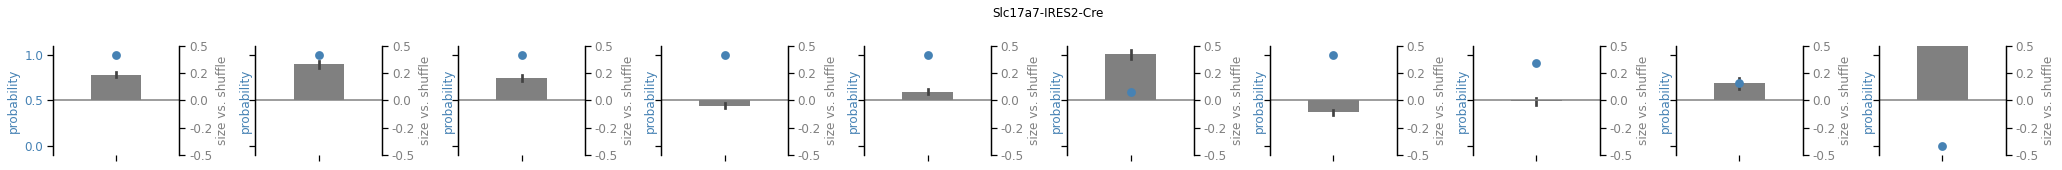

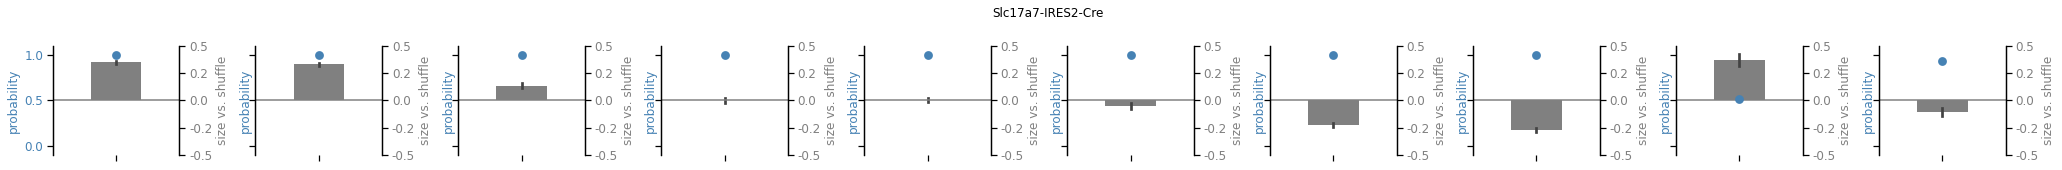

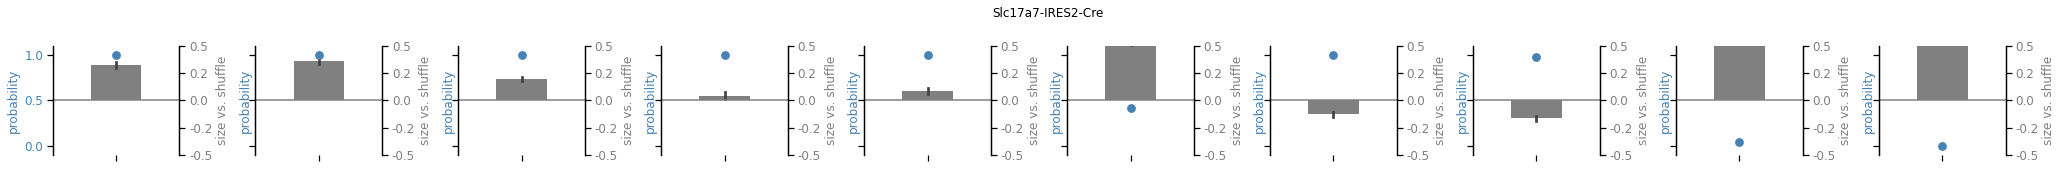

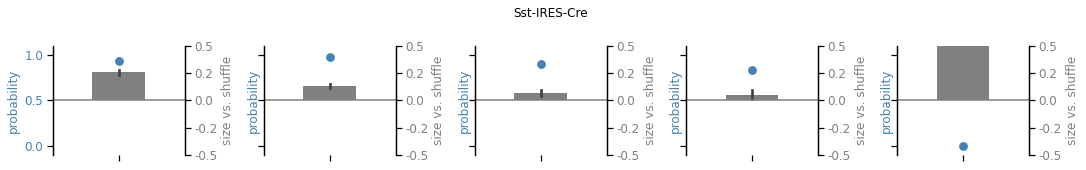

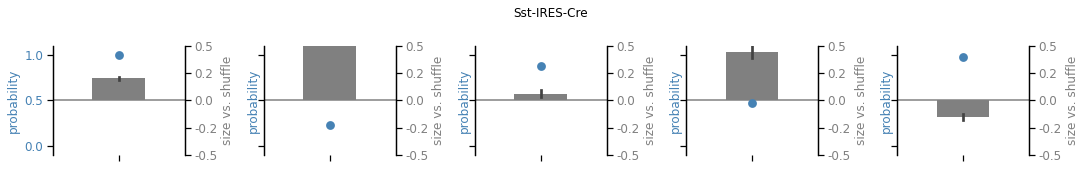

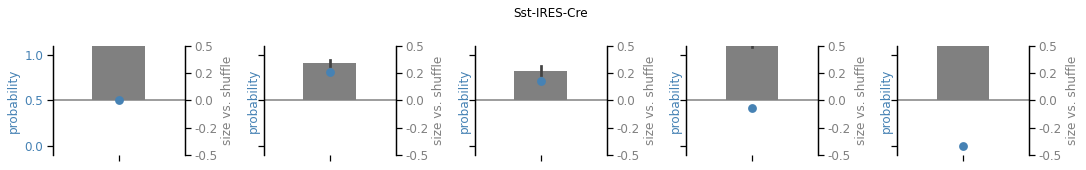

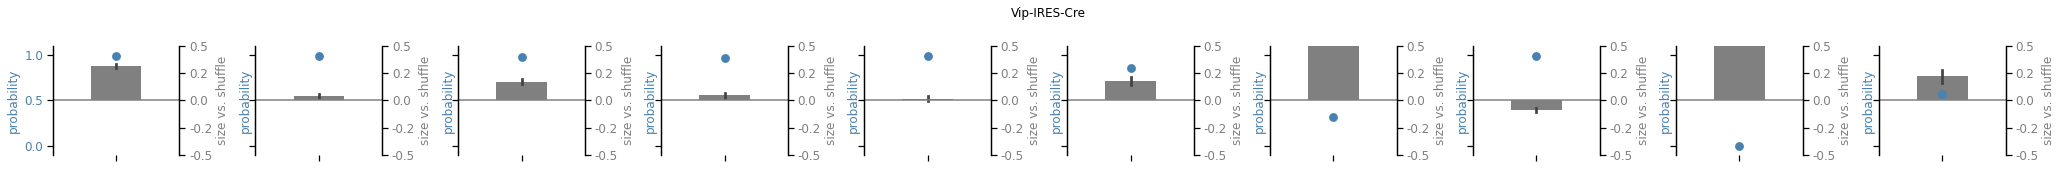

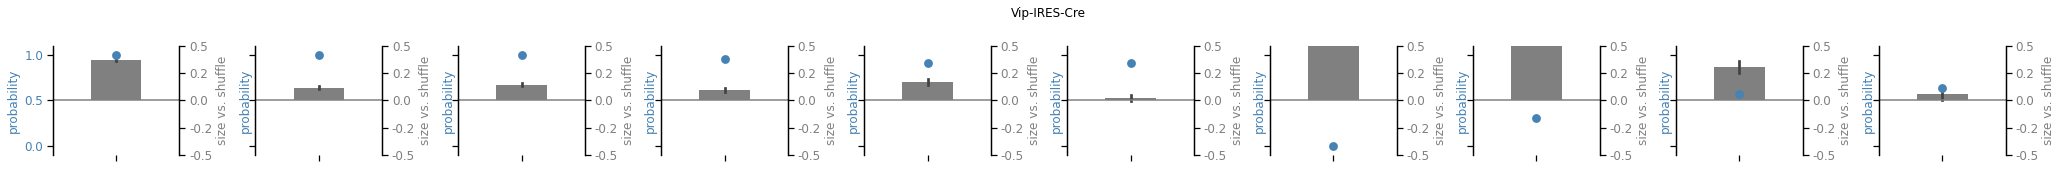

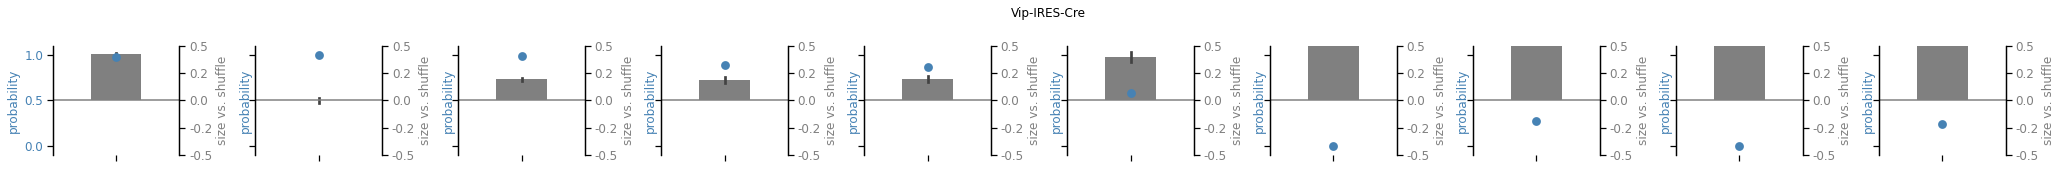

In [46]:
%%capture --no-display 
for threshold in thresholds:
    for cre_line in cre_lines:
        for s, shuffle_type in enumerate(shuffle_types):
            vba_clust.plot_cluster_size_and_probability(cluster_size_difference_dict[threshold], 
                                                        probability_dict[threshold], 
                                                        cre_line=cre_line, 
                                                        shuffle_type=shuffle_type,
                                                       save_dir=save_dir,
                                                       folder = f'{shuffle_type}{threshold}')


#### plot mean heatmap of matched clusters

to do:
    fix this plotting function

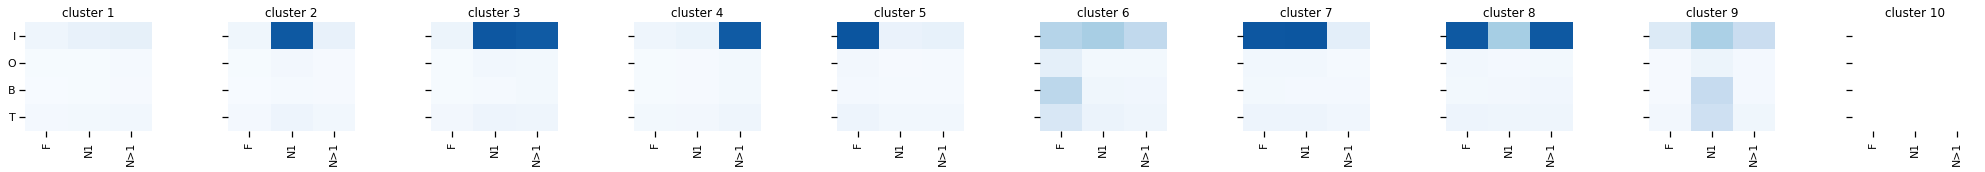

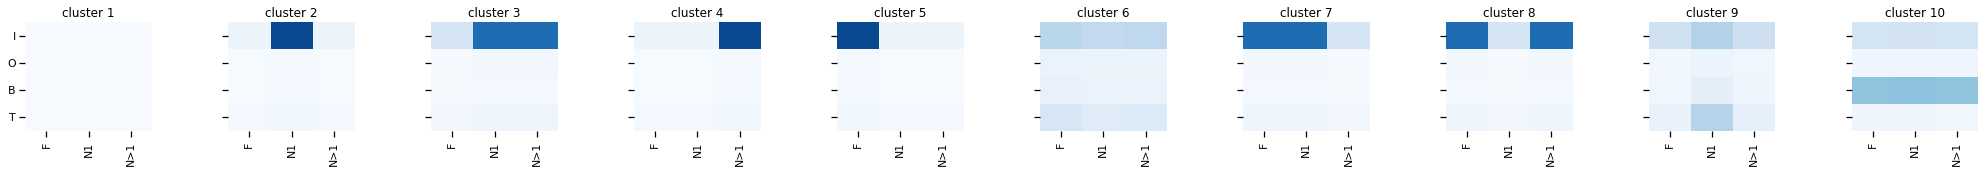

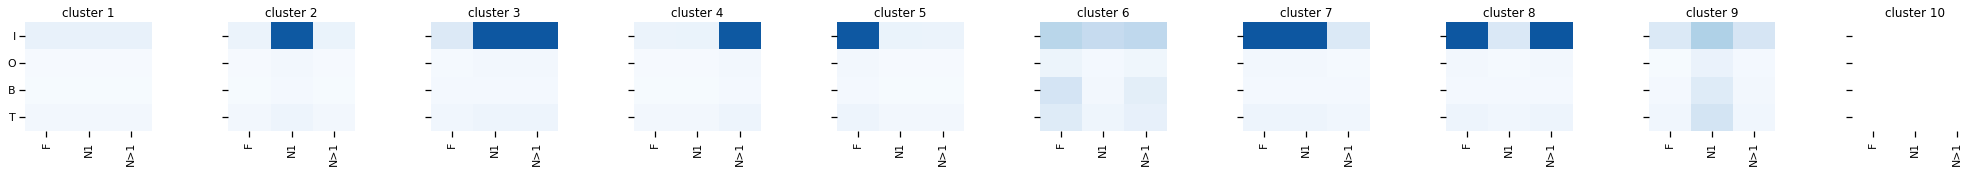

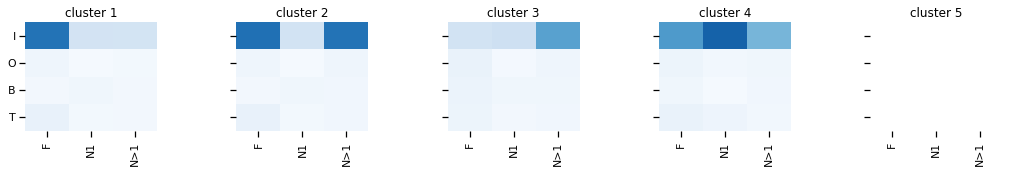

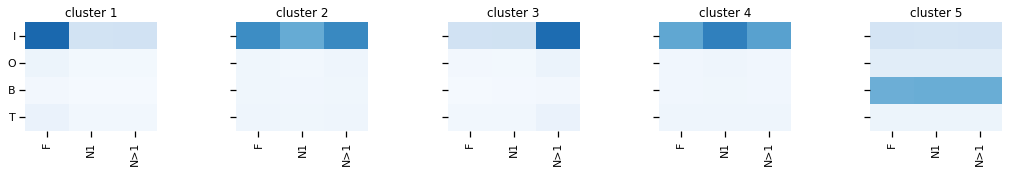

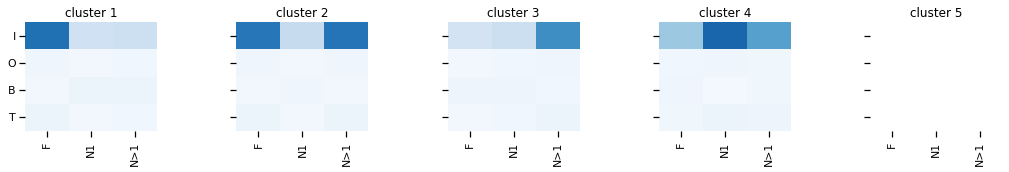

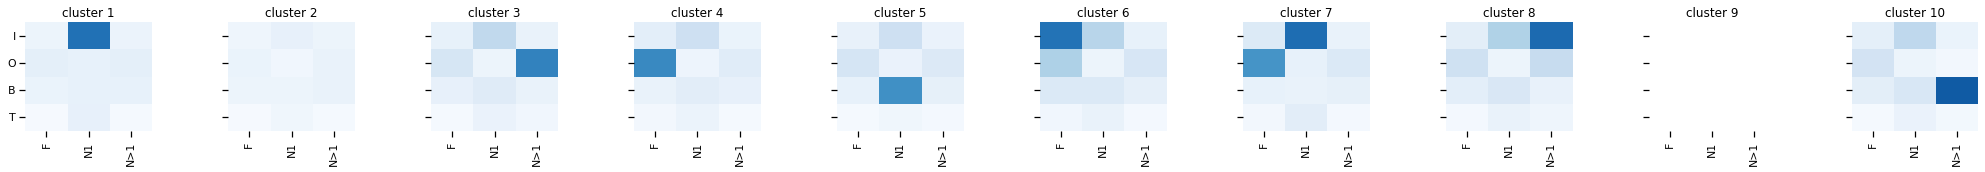

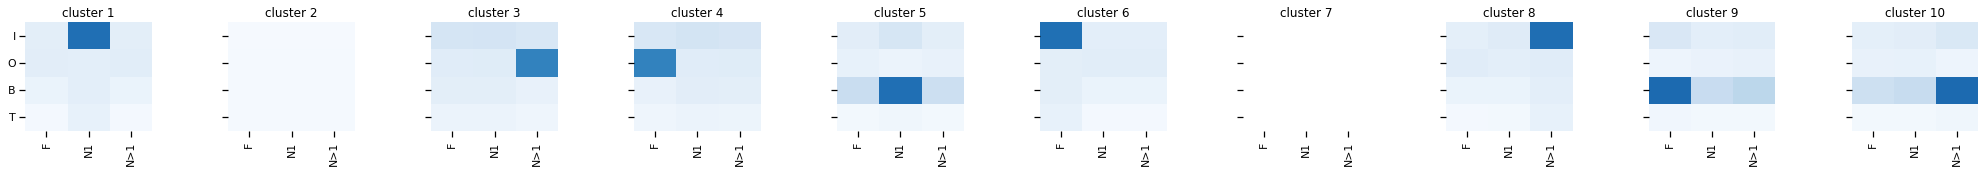

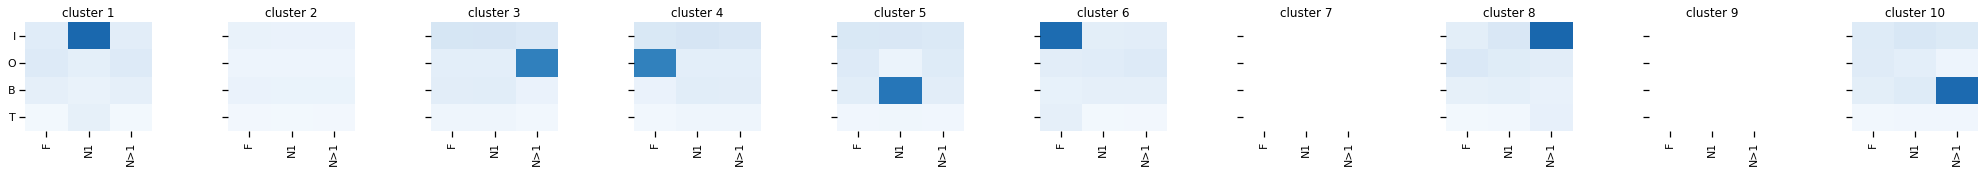

In [47]:
for threshold in thresholds:
    for cre_line in cre_lines:
        for shuffle_type in shuffle_types:
            vba_clust.plot_matched_clusters_heatmap(SSE_mapping = threshold_SSE_mapping[threshold], 
                                                    mean_dropout_scores_unstacked= shuffle_type_mean_dropout_scores_unstacked ,
                                                    cre_line=cre_line, metric='mean',
                                                    shuffle_type=shuffle_type, save_dir=save_dir, folder=f'{shuffle_type}{threshold}')



In [48]:
threshold_corr_dict = {}
for threshold in thresholds:
    shuffle_corr_dict = {}
    for shuffle_type in shuffle_types:
        corr_dict = {}
        for cre_line in cre_lines:
            corr_dict[cre_line]= vba_clust.get_corr_for_matched_clusters_dict(shuffle_type_SSE_mapping, 
                                                           shuffle_type_mean_dropout_scores,
                                                            shuffle_type = shuffle_type,
                                                           cre_line = cre_line)
        shuffle_corr_dict[shuffle_type] = corr_dict
    threshold_corr_dict[threshold] = shuffle_corr_dict

C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == "":
C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


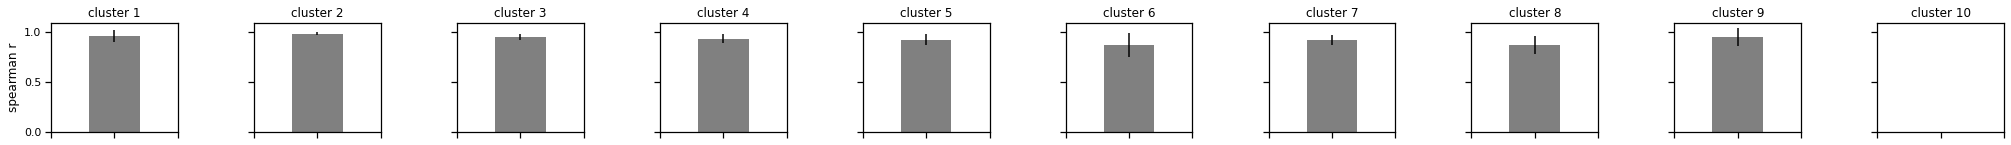

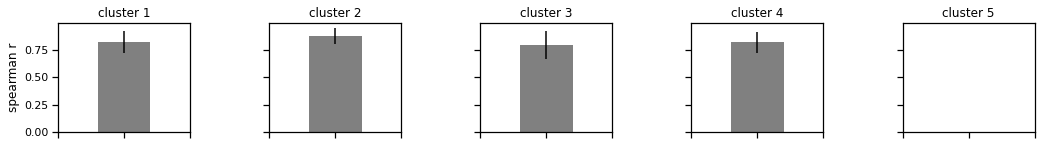

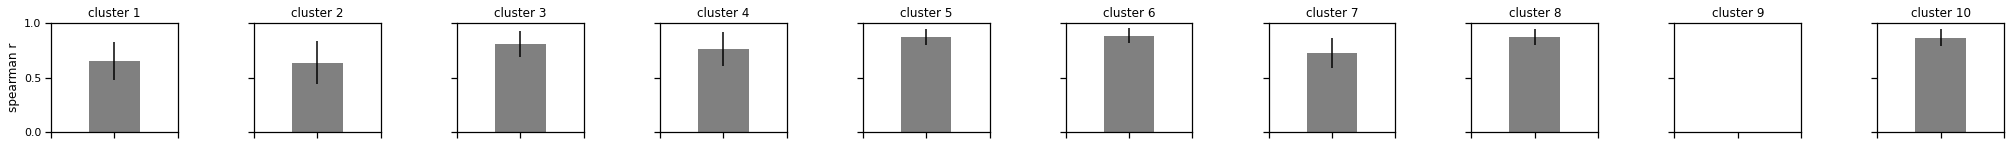

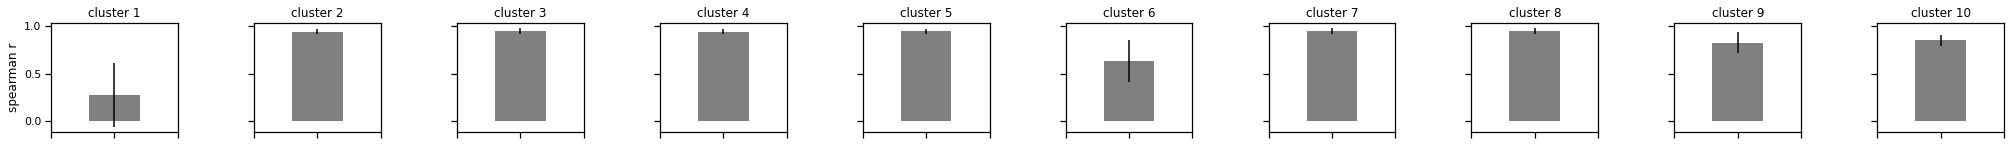

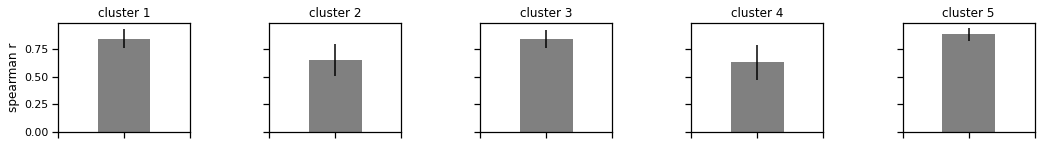

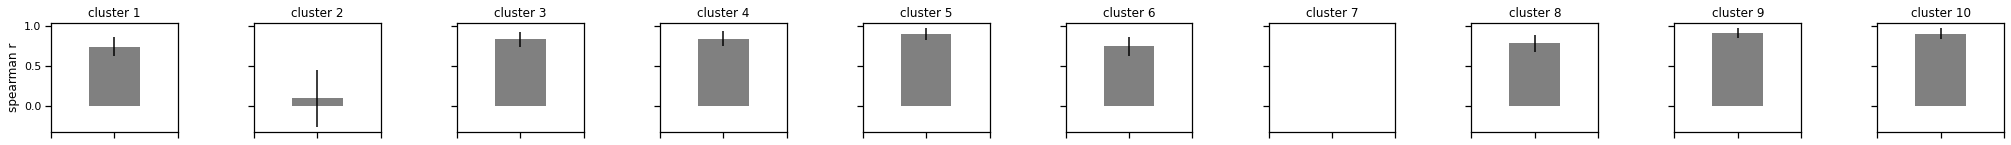

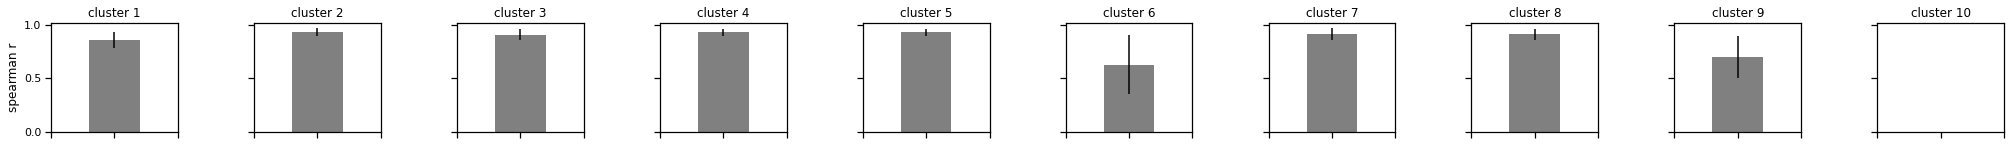

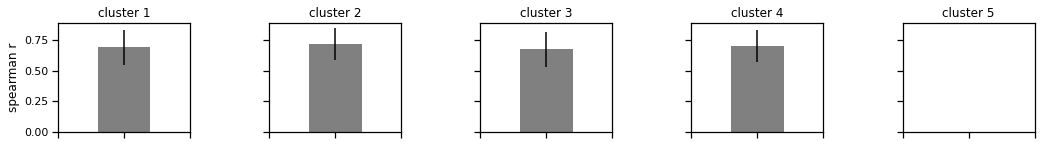

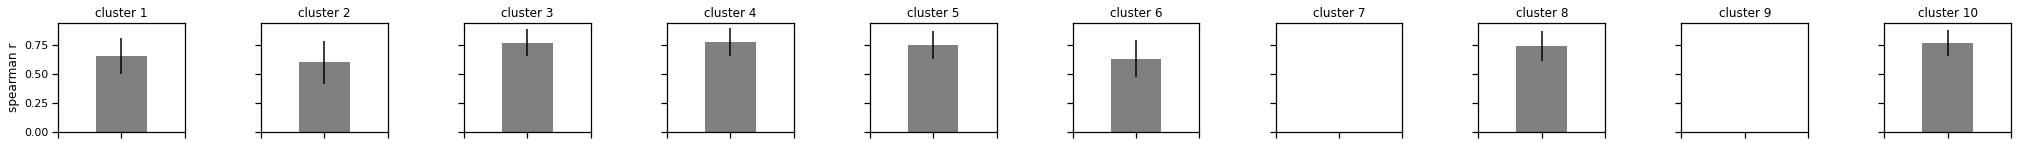

In [49]:
for threshold in thresholds:
    for shuffle_type in shuffle_types:
        for cre_line in cre_lines:
            corr_dict = threshold_corr_dict[threshold][shuffle_type][cre_line]
            n_clusters = len(corr_dict.keys())
            figsize=(3.5*n_clusters,2)
            fig, ax = plt.subplots(1,n_clusters, figsize = figsize, sharey='row')
            for i, cluster_id in  enumerate(corr_dict.keys()):
                ax[i].bar(cluster_id, corr_dict[cluster_id][0], color='Grey')
                ax[i].errorbar(cluster_id, corr_dict[cluster_id][0], corr_dict[cluster_id][1], 
                            color='k')
                ax[i].set_xticklabels([cluster_id])
                if i ==0 :
                    ax[i].set_ylabel('spearman r')
                ax[i].set_xlabel('')
                ax[i].set_title(f'cluster {cluster_id}')
                ax[i].set_xticklabels('')
                ax[i].set_xlim([cluster_id-1, cluster_id+1])

            #plt.suptitle(cre_line + ' ' + shuffle_type)
            fig.subplots_adjust(hspace=1.2, wspace=0.6)
            utils.save_figure(fig, figsize, save_dir, f'{shuffle_type}{threshold}',
                          f'{shuffle_type}_spearman_within_matched_' + cre_line[:3]  )


### try to match SSE values for mean plots

In [50]:
def make_dict(matrix):
    rows = np.shape(matrix)[0]
    new_dict = {}
    for row in range(rows):
        new_dict[row+1] = matrix[row]
    
    return new_dict

In [51]:
%%time

shuffle_type_SSE_all = {}
for shuffle_type in shuffle_types:
    cre_SSE_all = {}
    for cre_line in cre_lines:
        
        n_boots = shuffle_type_SSE[shuffle_type][cre_line].keys()
        cluster_ids = shuffle_type_SSE_mapping[shuffle_type][cre_line][0]
        
        # create a data frame to collect sorted SSE from all n_boots
        SSE_values_sorted_df = pd.DataFrame(columns=['cluster_id', *cluster_ids])
        
        # run over all nboots and sort SSE using orignal cluster sort
        for n in n_boots:
            
            # Get matched map and SSE matrix for this n boot
            SSE_values = shuffle_type_SSE[shuffle_type][cre_line][n]
            SSE_map = threshold_SSE_mapping[threshold][shuffle_type][cre_line][n]
            #print(SSE_map)
            # convert SSE matrix to df for easier operation
            nb_values_df = pd.DataFrame(make_dict(SSE_values))
            #print(nb_values_df)
            # make a copy which will be used to store sorted SSE values
            nb_sorted_df = nb_values_df.copy()
            # first sort SSE values
            for cluster_id in SSE_map.keys():
                matched_cluster_id = SSE_map[cluster_id] # matched shuddled cluster id
                
                # copy matched SSE value to a new location in df
                if matched_cluster_id!=-1:
                    nb_sorted_df.loc[cluster_id-1][:] = nb_values_df.loc[matched_cluster_id-1][:].values
                else:
                    #nb_sorted_df.loc[cluster_id-1][cluster_id]=np.nan
                    nb_sorted_df.loc[cluster_id-1][:]=np.nan
            
            
            # reset index and rename cluster id column
            nb_sorted_df = nb_sorted_df.reset_index(drop=True)
            nb_sorted_df['cluster_id'] = np.arange(1, len(cluster_ids)+1)
            
            
            # append to larger df with all n_boots
            SSE_values_sorted_df = SSE_values_sorted_df.append(nb_sorted_df, ignore_index=True)
        cre_SSE_all[cre_line] = SSE_values_sorted_df
    shuffle_type_SSE_all[shuffle_type] = cre_SSE_all
                
    
    

Wall time: 17.2 s


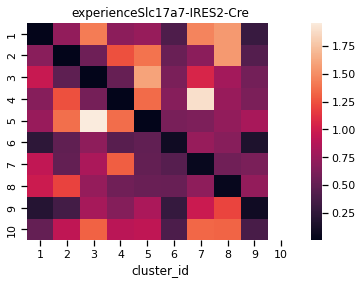

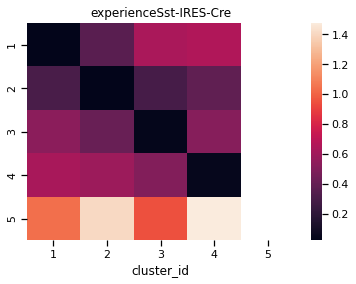

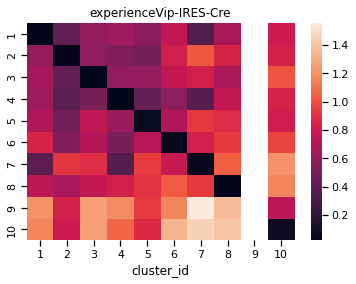

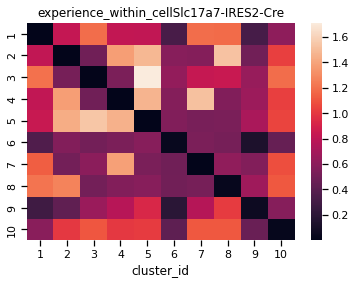

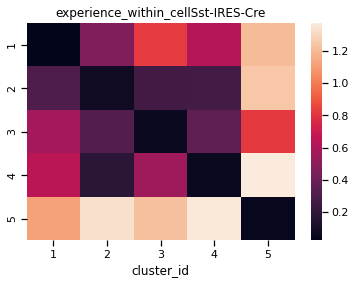

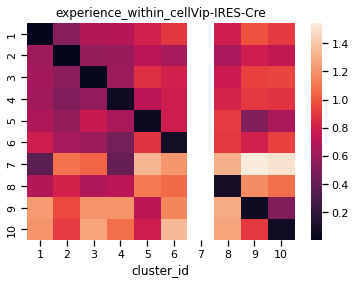

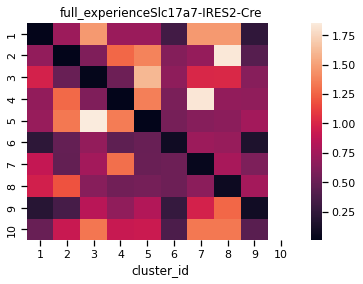

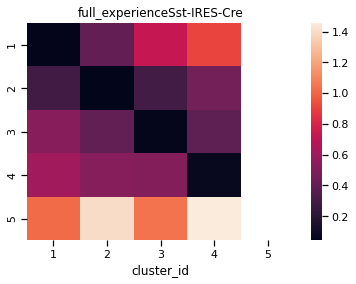

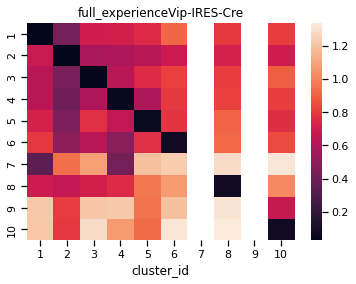

In [52]:
for shuffle_type in shuffle_types:
    for cre_line in cre_lines:
        sns.heatmap(np.transpose(shuffle_type_SSE_all[shuffle_type][cre_line].groupby('cluster_id').mean()))
        plt.title(shuffle_type + cre_line)
        plt.show()
                                                                         

#### plot heatmap of mean SSE values by with cluster id heatmaps

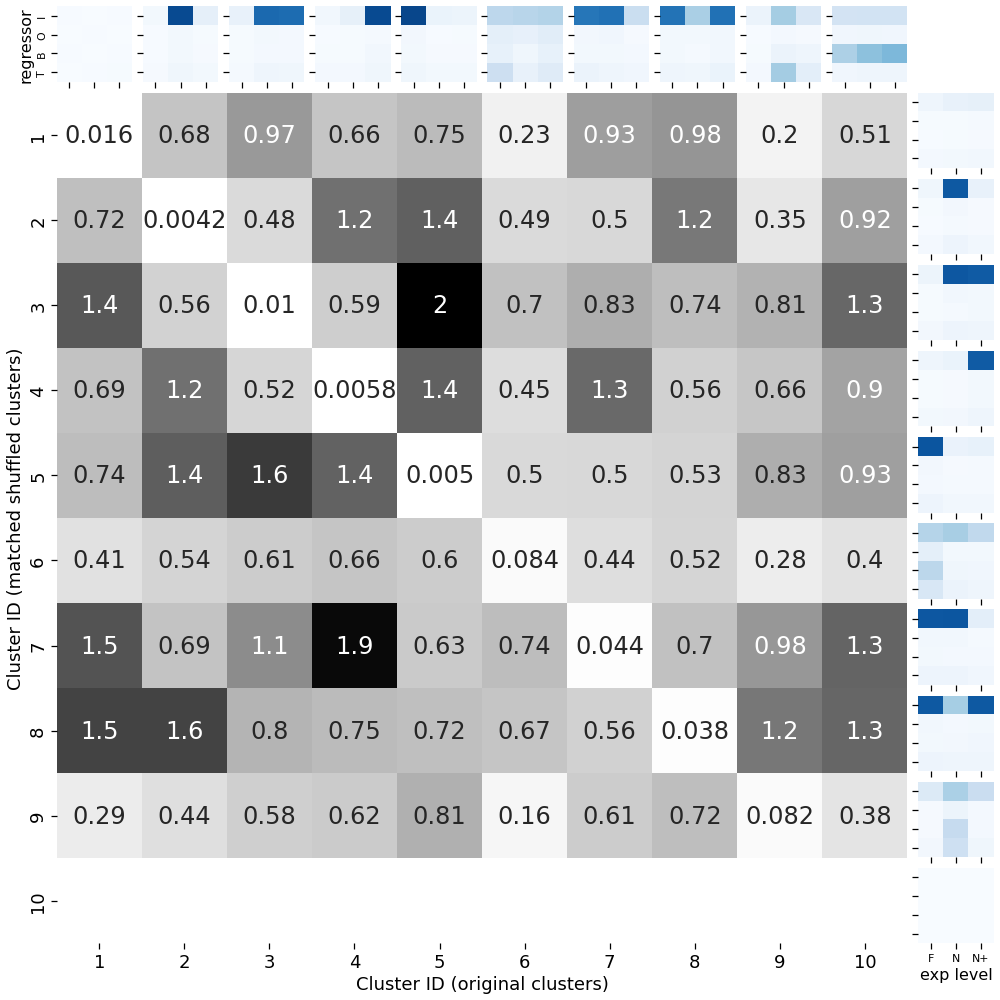

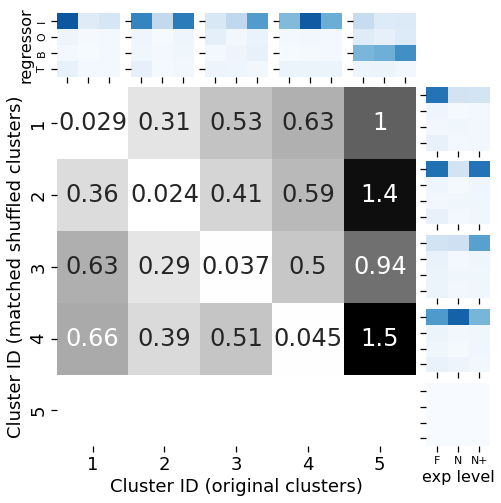

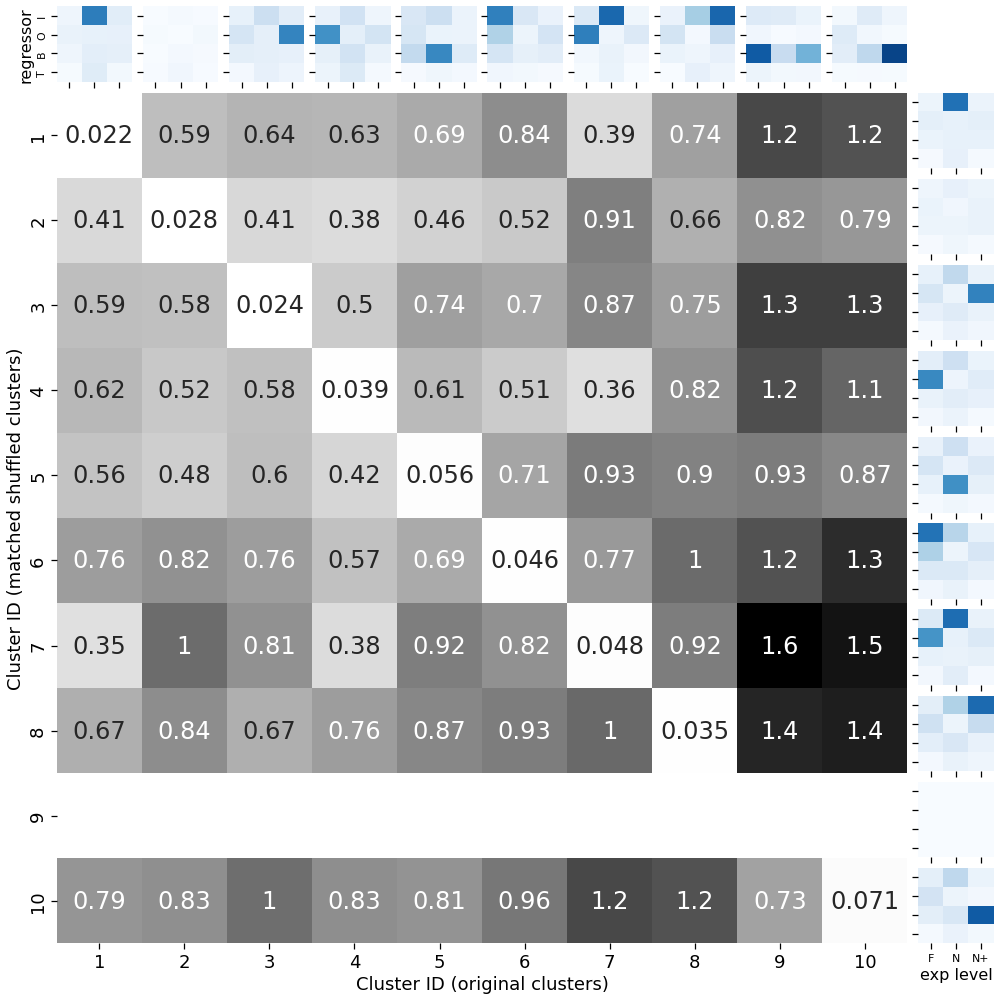

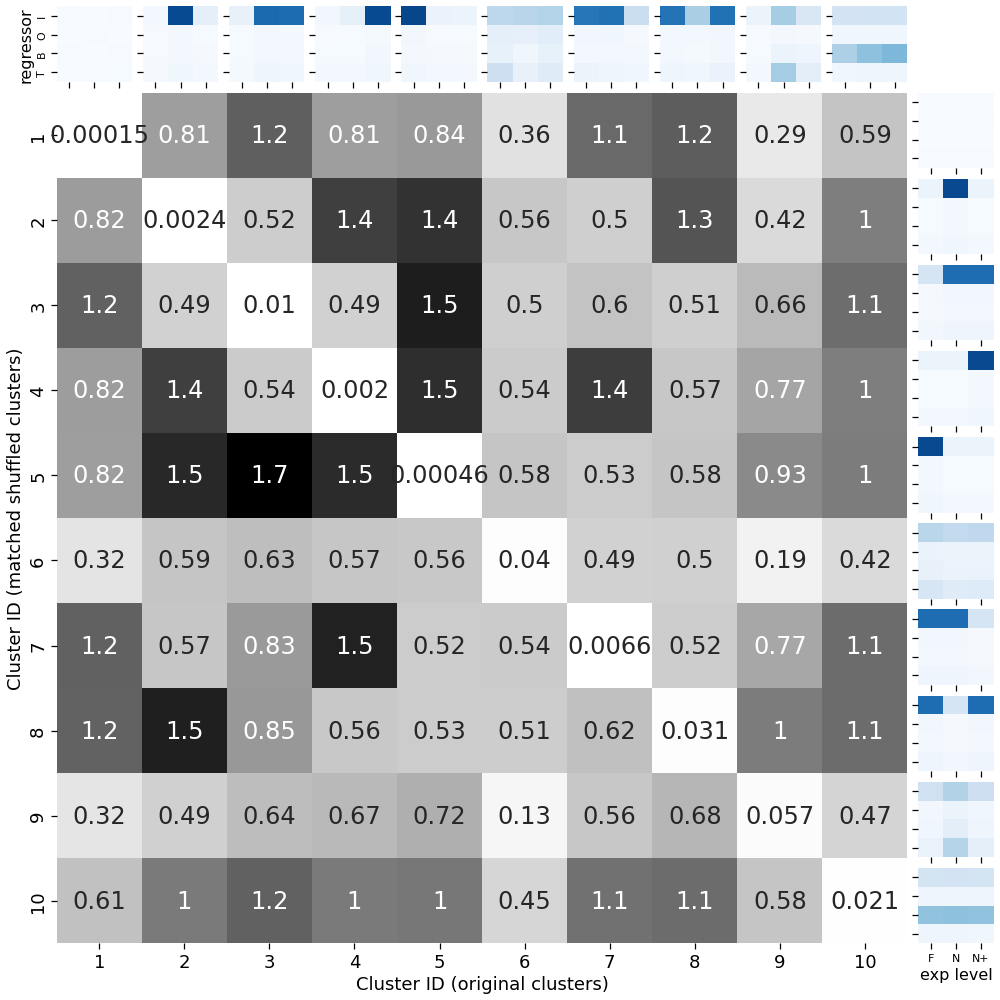

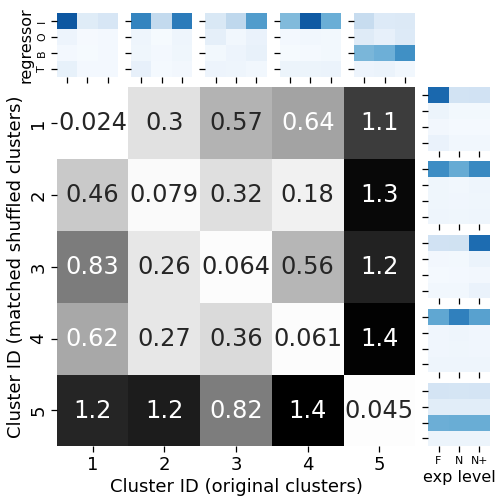

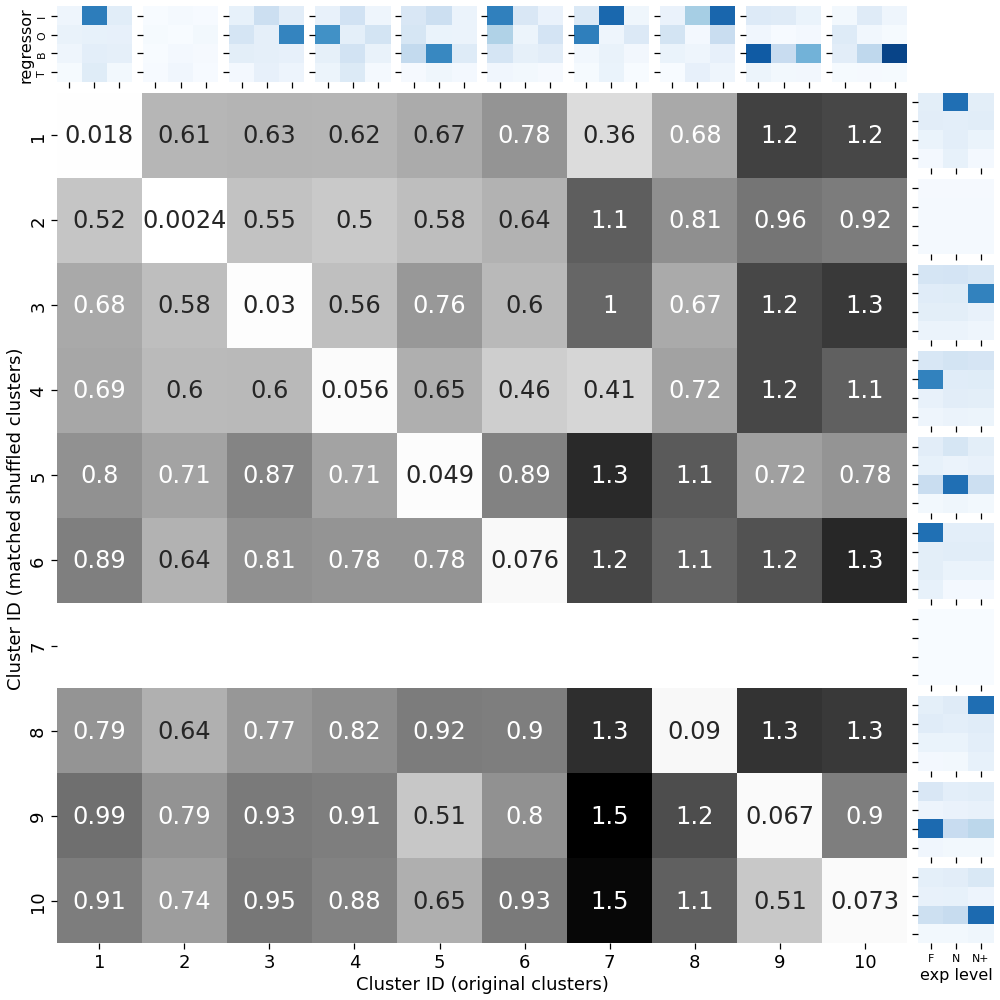

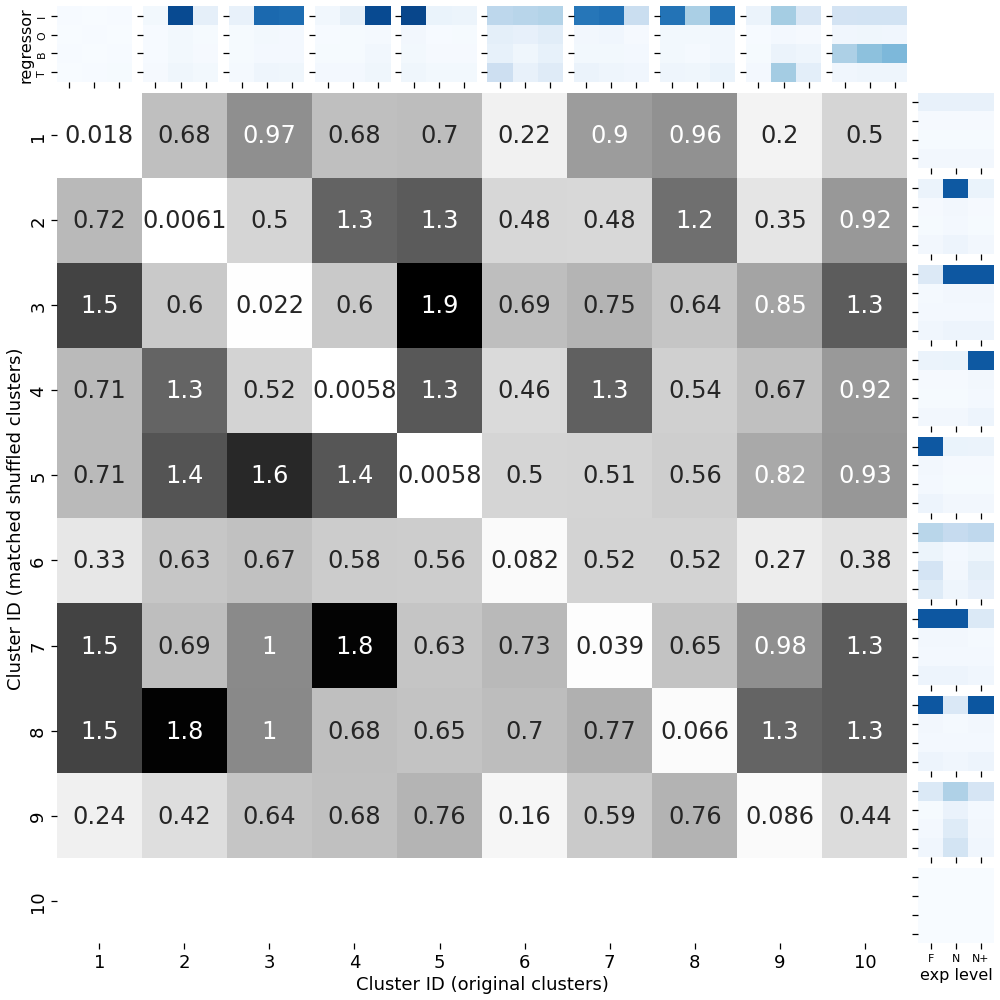

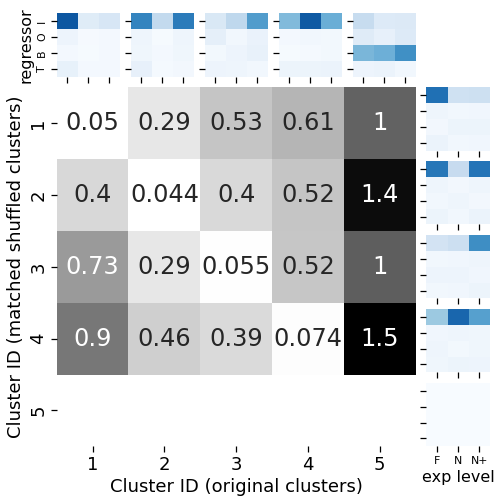

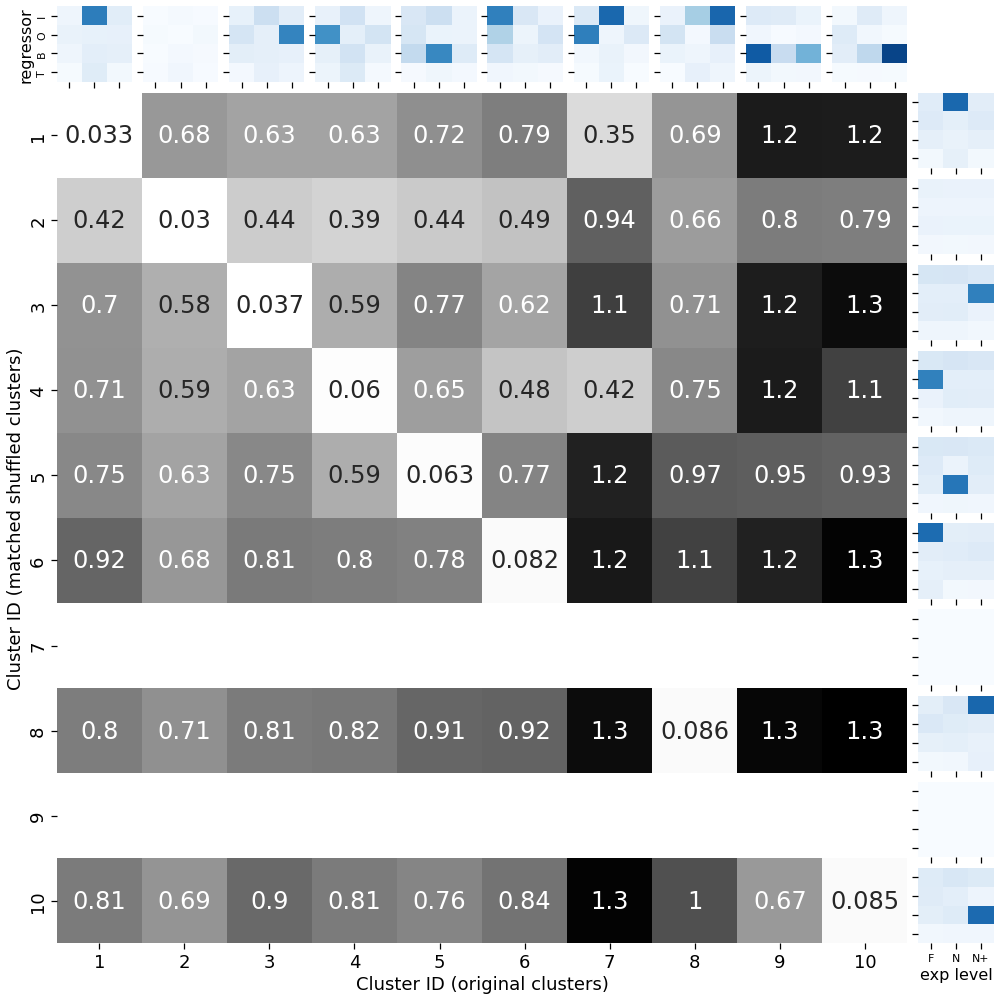

In [53]:
### make one mean figure with diagonal SSE matching plot

import matplotlib.gridspec as gr
figsizes =  [(14,14), (7, 7), (14,14)]
for shuffle_type in shuffle_types:
    for c,cre_line in enumerate(cre_lines):
        SSE_mapping = threshold_SSE_mapping[threshold]
        
        shuffled = vba_clust.get_matched_clusters_means_dict(SSE_mapping, shuffle_type_mean_dropout_scores_unstacked, metric='mean', shuffle_type=shuffle_type,
                                    cre_line=cre_line)      
        original = cre_original_clusters_unstacked[cre_line]
        cluster_ids = shuffled.keys()
        n_clusters = len(cluster_ids)
            
            
        gs = gr.GridSpec(n_clusters+1, n_clusters+1, width_ratios=[2]*(n_clusters+1), height_ratios=[2]*(n_clusters+1))
        fig = plt.figure(figsize = figsizes[c])
            
        # plot original
        for i, cluster_id in enumerate(cluster_ids):
            ax = fig.add_subplot(gs[0, i])
            ax = sns.heatmap(original[cluster_id].loc[vba_clust.get_features_for_clustering()],
                xticklabels=['F', 'N', 'N+'],yticklabels=['I', 'O', 'B', 'T'],
                cmap = "Blues",vmin=0, vmax=1,cbar=False, ax=ax)
            if i!=0:
                ax.set_yticklabels('')
            else:
                ax.set_ylabel('regressor', fontsize=16)
            ax.set_xticklabels('')
            ax.set_xlabel('')

        # plot shuffled clusters
        for i, cluster_id in enumerate(cluster_ids):
            ax = fig.add_subplot(gs[cluster_id, n_clusters])
            ax = sns.heatmap(shuffled[cluster_id].loc[vba_clust.get_features_for_clustering()],
                xticklabels=['F', 'N', 'N+'],yticklabels=['I', 'O', 'B', 'T'],
                cmap = "Blues",vmin=0, vmax=1,cbar=False, ax=ax)
            ax.set_yticklabels('')
            ax.set_xlabel('')
            ax.set_ylabel('')
            if cluster_id !=n_clusters:
                ax.set_xticklabels('')
            else:
                ax.set_xlabel('exp level', fontsize=16)


         # Plot SSE
        tmp = shuffle_type_SSE_all[shuffle_type][cre_line].groupby('cluster_id').mean()        
        labels=np.arange(1,len(tmp)+1)
        ax = fig.add_subplot(gs[1:,:n_clusters])
        ax=sns.heatmap(tmp, annot=True, cmap = 'Greys', annot_kws= {"size": 24},
                            yticklabels=labels, xticklabels=labels,cbar=False,ax=ax)
        
        ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 18)
        ax.set_ylabel('Cluster ID (matched shuffled clusters)', fontsize=18)
        ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 18)
        ax.set_xlabel('Cluster ID (original clusters)', fontsize=18)

        plt.tight_layout()
        utils.save_figure(fig, figsize = figsizes[c], save_dir=save_dir, folder='mean_SSE_plots',
                      fig_title=f'mean_SSE_heatmap_{shuffle_type}_{cre_line[:3]}')
        


In [54]:
from scipy.stats import chisquare
from scipy.stats import power_divergence
from scipy.stats import fisher_exact

In [55]:
cluster_size_difference_dict[threshold]
                                                        

,cre_line,cluster_id,shuffle_type,n_boot,cluster_size_diff
0,Slc17a7-IRES2-Cre,1,experience,0,0.071167
1,Slc17a7-IRES2-Cre,1,experience,1,-0.094854
2,Slc17a7-IRES2-Cre,1,experience,2,0.457086
3,Slc17a7-IRES2-Cre,1,experience,3,-0.086929
4,Slc17a7-IRES2-Cre,1,experience,4,0.081481
...,...,...,...,...,...
37495,Vip-IRES-Cre,10,full_experience,495,1.000000
37496,Vip-IRES-Cre,10,full_experience,496,-0.388889
37497,Vip-IRES-Cre,10,full_experience,497,-0.463415
37498,Vip-IRES-Cre,10,full_experience,498,-0.333333


In [56]:
probability_dict[threshold]

,cre_line,cluster_id,shuffle_type,probability
0,Slc17a7-IRES2-Cre,1,experience,1.000
1,Slc17a7-IRES2-Cre,2,experience,1.000
2,Slc17a7-IRES2-Cre,3,experience,1.000
3,Slc17a7-IRES2-Cre,4,experience,1.000
4,Slc17a7-IRES2-Cre,5,experience,1.000
...,...,...,...,...
70,Vip-IRES-Cre,6,full_experience,0.578
71,Vip-IRES-Cre,7,full_experience,0.000
72,Vip-IRES-Cre,8,full_experience,0.274
73,Vip-IRES-Cre,9,full_experience,0.000
